### Breast ultrasound dataset

In [2]:
>import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf

Il dataset è composto da 780 immagini di ecografie al seno mediamente di 500x500, divise in normali, benigne e maligne. Siccome a noi interessa solo segmentare l'area interessata al tumore e non capire se è maligno o benigno, escludiamo questa classificazione e consideriamo il dataset come unico (ho mantenuto la classe quando lo creo solo per visualizzare solo le maschere dei tumori). Come ground truth usiamo una maschera in cui l'area bianca è l'area della lesione. Per aprire correttamente il dataset scaricatelo da Kaggle (https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset?resource=download), unzippatelo e mettetelo nella cartella del progetto.

In [3]:
directory = "Dataset_BUSI_with_GT"
categories = ["benign", "malignant"]

image_and_mask_list = []

for category in categories:
    path = os.path.join(directory, category)

    #get all files in the folder
    files = os.listdir(path)

    #separate images and masks
    images = [f for f in files if not f.endswith("_mask*.png")]
    masks = [f for f in files if f.endswith("_mask.png")]

    #match images with their masks
    for image in images:
        mask_name = f"{os.path.splitext(image)[0]}_mask.png"
        if mask_name in masks:
            image_path = os.path.join(path, image)
            mask_path = os.path.join(path, mask_name)
            image_and_mask_list.append((image_path, mask_path))

print(f"Found {len(image_and_mask_list)} image-mask pairs.")

Found 647 image-mask pairs.


Image: Dataset_BUSI_with_GT\benign\benign (1).png


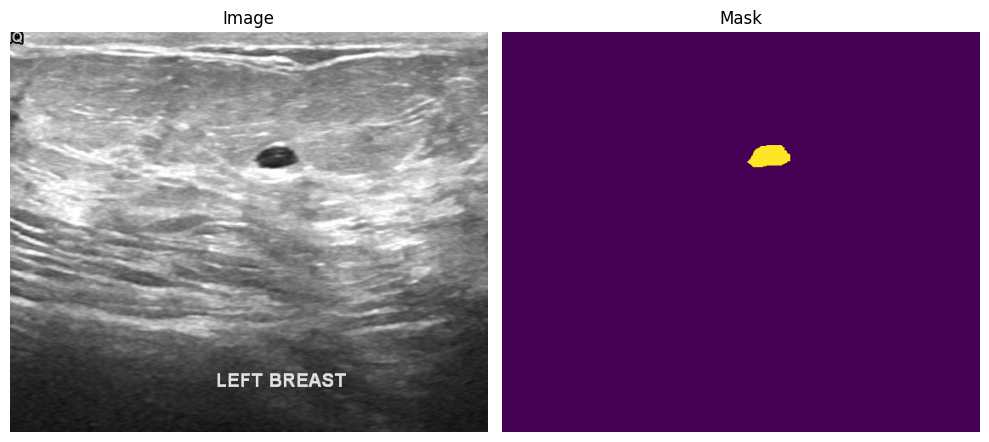

Image: Dataset_BUSI_with_GT\benign\benign (10).png


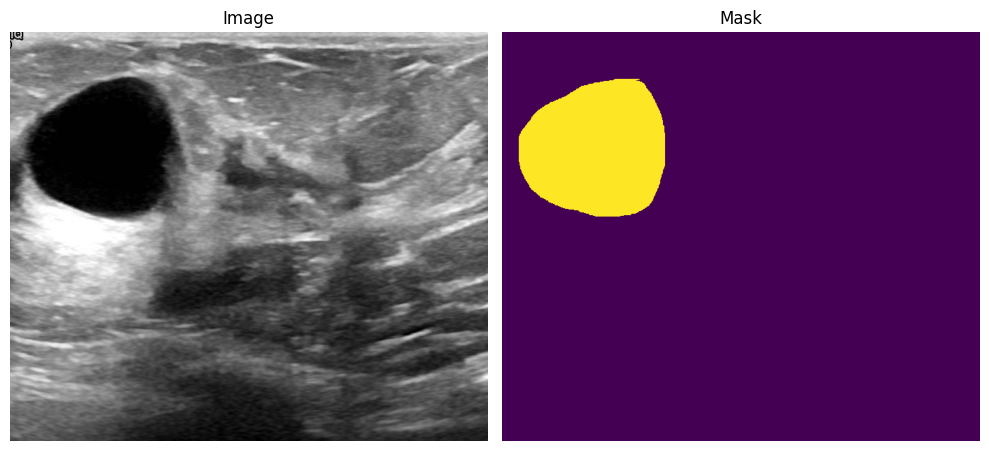

Image: Dataset_BUSI_with_GT\benign\benign (100).png


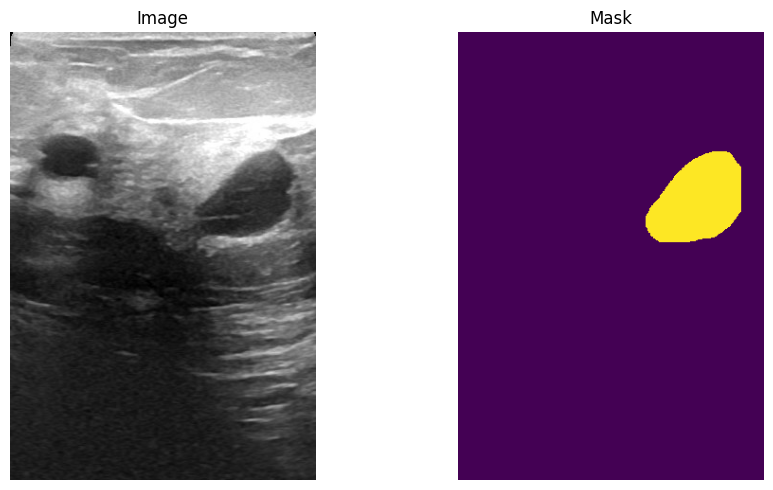

Image: Dataset_BUSI_with_GT\benign\benign (101).png


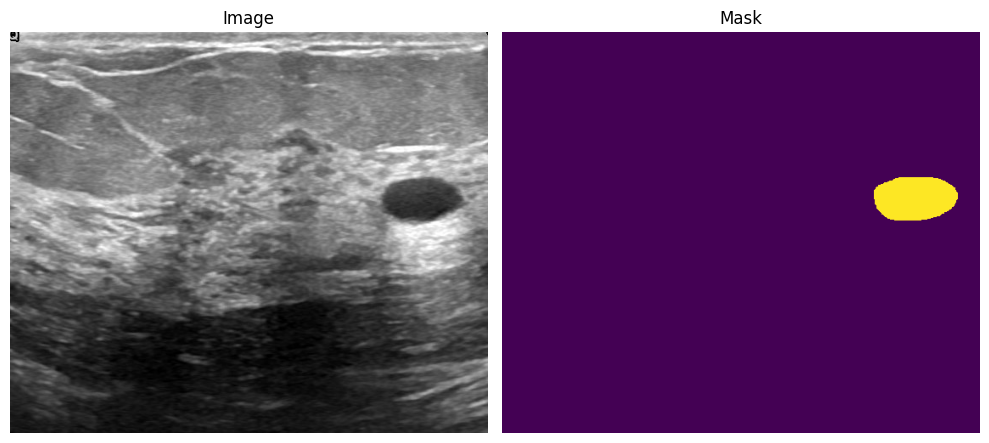

Image: Dataset_BUSI_with_GT\benign\benign (102).png


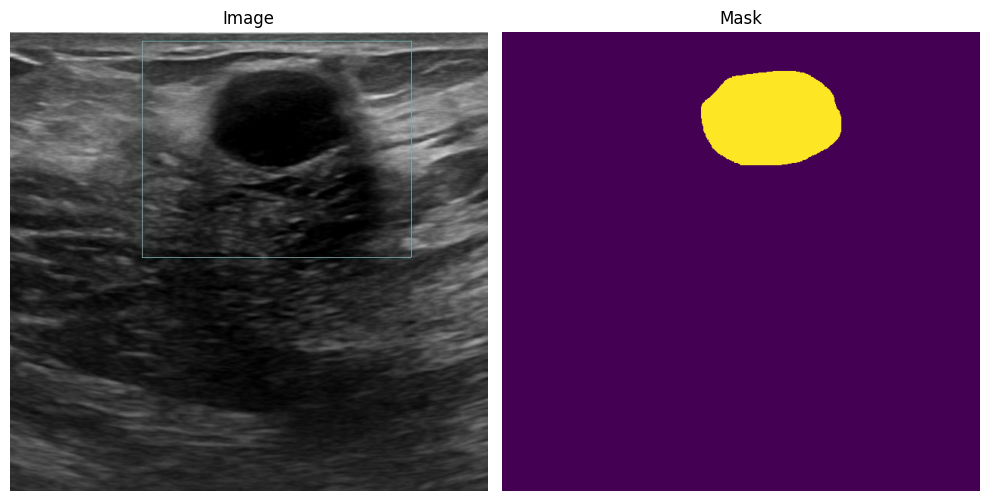

In [13]:
#visualize the first three image and mask pairs for the malignant tumors
for i in range(5):
    image_path, mask_path = image_and_mask_list[i]
    print(f"Image: {image_path}")
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display first image
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')

    # Display second image
    ax2.imshow(mask)
    ax2.set_title('Mask')
    ax2.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [14]:
image_size = (256, 256)
batch_size = 16

In [15]:
def load_images_and_masks(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_size)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, image_size)

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask

In [16]:
def create_dataset(pairs, batch_size):
    image_path = [pair[0] for pair in pairs]
    mask_path = [pair[1] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((image_path, mask_path))

    dataset = dataset.map(lambda image, mask: load_images_and_masks(image, mask), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

In [ ]:
from